# predict suicides 

## TODO
1. create a categorical label encoder pipeline so i can reuse code
2. practice tuning by hand and assessing fit (if overfit then counter)
3. practice auto tuning and compare
4. with best tuned results - compare scaling vs not scaling

In [429]:
#https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016

In [430]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time
from sklearn.model_selection import GridSearchCV, KFold
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from fast_ml.model_development import train_valid_test_split

import requests
from sklearn.pipeline import Pipeline
import pandas as pd
import io
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
base_dir = 'D:/Projects/Prediction/Techniques Practice/Trees/XGBoost'
data_set_dir = '/Suicides/temp data'
temp_dir = base_dir+data_set_dir
dataset_url = "https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016/download"
os.mkdir(temp_dir)
os.chdir(temp_dir)

!kaggle datasets download -d russellyates88/suicide-rates-overview-1985-to-2016/download

os.chdir('D:\\Projects\\Prediction\\Techniques Practice\\Trees\\XGBoost\\Suicides\\')

import zipfile
with zipfile.ZipFile('./temp data/suicide-rates-overview-1985-to-2016.zip', "r") as z:
    z.extractall('./temp data')
os.remove('./temp data/*.zip')

os.remove('./temp data/suicide-rates-overview-1985-to-2016.zip')

In [431]:
suicides_df = pd.read_csv('./temp data/master.csv')
suicides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [432]:
# dataset approx 30k rows and 12 cols. 
# all rows have 'full' info besides for HDI for year. (human development index)

In [433]:
np.corrcoef(suicides_df.suicides_no, suicides_df['suicides/100k pop'])[0][1]

0.3066044512677834

In [434]:
suicides_df = suicides_df.drop('country-year',axis=1)

<AxesSubplot:ylabel='country'>

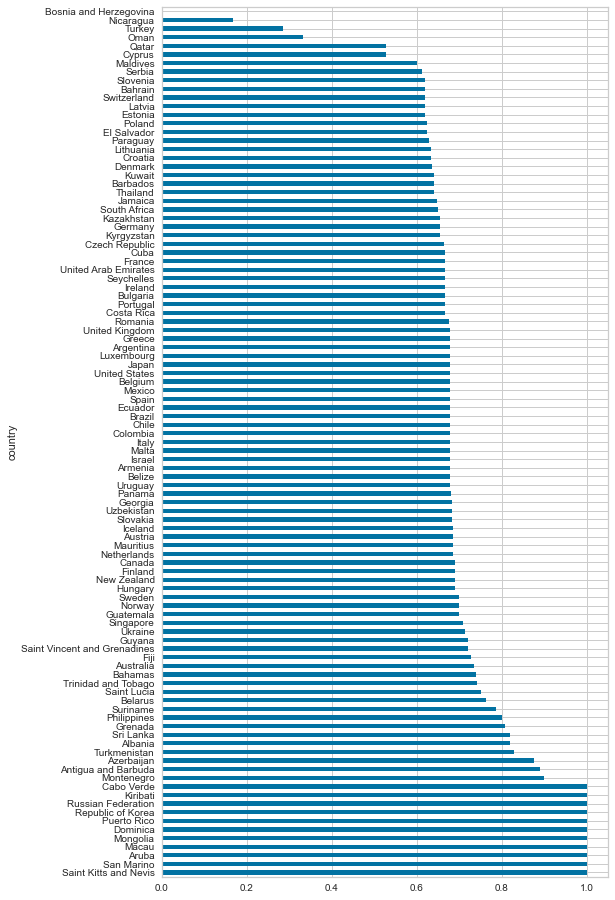

In [435]:
# lets first work with HDI
plt.figure (figsize= (8,16))
country_grps = suicides_df.groupby('country')
(country_grps.apply(lambda grp: grp['HDI for year'].isnull().sum())/country_grps['HDI for year'].apply(len)).sort_values(ascending=False).plot(kind='barh')

In [436]:
suicides_df['country'] = suicides_df['country'].astype('category')
suicides_df['sex'] = suicides_df['sex'].astype('category')
suicides_df['age'] = suicides_df['age'].astype('category')
suicides_df = suicides_df.rename({'suicides/100k pop':'suicides_p100k', ' gdp_for_year ($) ':'gdp_for_year','gdp_per_capita ($)':'gdp_per_capita'},axis=1)
suicides_df['gdp_for_year'] = suicides_df['gdp_for_year'].apply(lambda row_str : row_str.replace(',','')).astype(float)
suicides_df['generation'] = suicides_df['generation'].astype('category')

In [437]:
inds_no_hdi = np.where((country_grps.apply(lambda grp: grp['HDI for year'].isnull().sum())/country_grps['HDI for year'].apply(len))==1)
countries_no_hdi = country_grps.all().index[inds_no_hdi]
#omg... I could do MICE? data has to be missing at random. I could look up HDI for countries mentioned on google then just fill for country?
countries_no_hdi

Index(['Aruba', 'Cabo Verde', 'Dominica', 'Kiribati', 'Macau', 'Mongolia',
       'Puerto Rico', 'Republic of Korea', 'Russian Federation',
       'Saint Kitts and Nevis', 'San Marino'],
      dtype='object', name='country')

In [438]:
(suicides_df.country.isin(countries_no_hdi)).sum() #can just fill one value for each country where hdi missing

1486

In [439]:
# http://hdr.undp.org/sites/all/themes/hdr_theme/country-notes/CPV.pdf#:~:text=Cabo%20Verde%E2%80%99s%20HDI%20value%20for%202018%20is%200.651%E2%80%94,0.564to%200.651%2C%20an%20increase%20of%20%20%20percent.
# ordered list of hdi per country in countries_no_hdi
missing_hdis = [0.908,0.64,0.724 ,0.630 ,0.922 ,0.735 ,0.86 ,0.906 ,0.824 ,0.779 ,0.96]
missing_hdis_dict = dict(zip(countries_no_hdi,missing_hdis))

In [440]:
suicides_df.loc[suicides_df.country.isin(countries_no_hdi),'HDI for year'] = suicides_df[suicides_df.country.isin(countries_no_hdi)].country.map(missing_hdis_dict)

In [441]:
suicides_df['HDI for year'] = suicides_df.groupby('country')['HDI for year'].transform(lambda grp: grp.ffill().bfill())

In [442]:
suicides_df.sample(5)

,country,year,sex,age,suicides_no,population,suicides_p100k,HDI for year,gdp_for_year,gdp_per_capita,generation
24067,Suriname,1987,male,5-14 years,0,41778,0.00,0.692,9.798500e+08,2951,Generation X
24228,Suriname,2003,male,15-24 years,7,43597,16.06,0.692,1.271196e+09,2916,Millenials
22408,Singapore,1985,female,15-24 years,25,253400,9.87,0.718,1.913830e+10,8142,Generation X
9103,France,1986,female,55-74 years,1203,5253800,22.90,0.741,7.714708e+11,14940,G.I. Generation
13748,Kazakhstan,1991,male,75+ years,74,101600,72.83,0.690,2.488114e+10,1664,G.I. Generation


In [443]:
# map age 
age_dct = dict(zip(list(set(suicides_df.age)),[1,2,3,0,4,5]))
suicides_df['age'] = suicides_df.age.map(age_dct)

In [444]:
y_train.flatten()

array([-0.27237016, -0.27237016, -0.22379817, ...,  0.24949634,
       -0.17635576, -0.27124058])

SCALED RMSE BASELINE: 0.821
RMSE BASELINE: 245.782
RMSE: 0.033


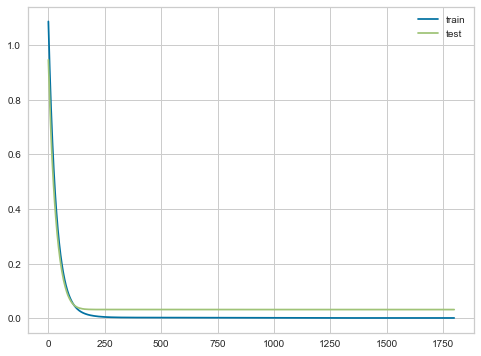

In [447]:
#lets just do this shit properly 
#https://medium.com/analytics-vidhya/how-to-apply-preprocessing-steps-in-a-pipeline-only-to-specific-features-4e91fe45dfb8

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


categorical_features = suicides_df.select_dtypes(include=['category']).columns
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_features = [x for x in suicides_df.columns if x not in categorical_features]
numeric_features.remove('suicides_no')
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numeric_transformer, numeric_features)
    ],
    remainder = 'drop'
)

pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('xgb_reg', xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)) 

    ]
)


##### ##### ##### NO TUNING ##### ##### #####

# fit the model
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(suicides_df, target = 'suicides_no', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)
#kak messy
preprocessor.fit(suicides_df)
X_train = preprocessor.transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)
target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1,1))
y_train = y_train.flatten()
y_val = target_scaler.transform(y_val.values.reshape(-1,1)) 
y_val = y_val.flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1,1))
y_test = y_test.flatten()

feature_names = list(preprocessor.transformers_[0][1][1].get_feature_names_out())+list( preprocessor.transformers_[1][2])

##### ##### ##### BASELINE ##### ##### #####
pred = [y_train.mean()]*len(y_val)
score = np.sqrt(mse(y_val, pred))
print('SCALED RMSE BASELINE: %.3f' % score)

pred = [target_scaler.inverse_transform(y_train.reshape(-1,1)).mean()]*len(y_val)
score = np.sqrt(mse(y_val, pred))
print('RMSE VALIDATION BASELINE: %.3f' % score)

pred = [target_scaler.inverse_transform(y_train.reshape(-1,1)).mean()]*len(y_val)
score = np.sqrt(mse(y_test, pred))
print('RMSE TEST BASELINE: %.3f' % score)

# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_val,y_val)]


model.fit(X_train, y_train, eval_metric='rmse', eval_set=evalset, verbose=0)
# evaluate performance
pred = model.predict(X_test)
score = np.sqrt(mse(y_test, pred))
print('DEFAULT PARAMS XGB RMSE: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()

plt.figure(figsize=(8,6))
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()


(1050.0499999999993, 22338)

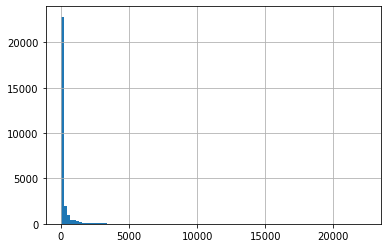

In [154]:
suicides_df['suicides_no'].hist(bins=100)
np.percentile(suicides_df['suicides_no'], 95), max(suicides_df['suicides_no']) #large outlier. might throw the prediction off. better to transform

In [254]:
#https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/#:~:text=There%20are%20two%20ways%20that%20you%20can%20scale,target%20variable.%20Automatically%20transform%20the%20target%20variable.%201.
#automatic scaling below, but I want to look at baseline based on scaled target. 
#model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())


Prediction Error Plot



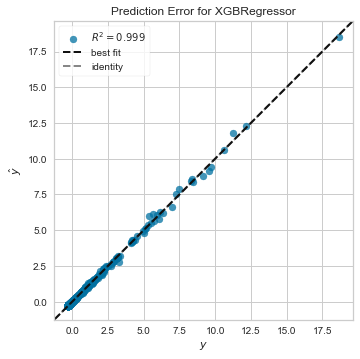

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1,
                                       enable_categorical=False, gamma=0,
                                       gpu_id=-1, importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.03, max_delta_step=0,
                                       max_depth=9, min_child_weight=1,
                                       missing=nan, monotone_constraints='()',
                                       n_estimators=1800, n_jobs=12,
                                       num_parallel_tree=1, predictor='auto',
                                       random_state=0, reg_alpha=0,
          

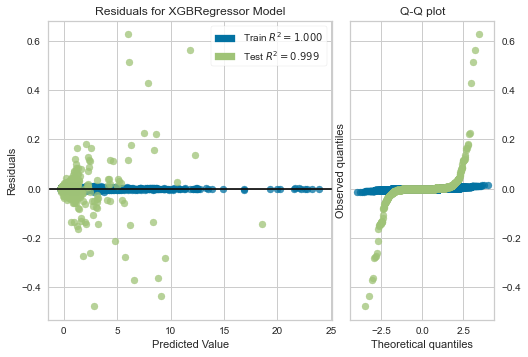

AttributeError: 'XGBRegressor' object has no attribute 'line_color'

In [448]:

# Making the Prediction Error Plot
print("\nPrediction Error Plot\n")
print(prediction_error(model, X_train, y_train, X_test, y_test))
## NOTE! this would be v cool to do with non-scaled version to see where the predictions are coming up correctly / incorrectly

# Making the Residuals Plot
print("\nResiduals Plot\n")
print(residuals_plot(model, X_train, y_train.flatten(), X_test, y_test.flatten(), qqplot=True, hist=False))

In [540]:
# huge huge improvement over baseline - clearly worth using model. 
# as a matter of fact, fit seems almost good enough not to tune? let's see improvements

In [542]:
xgb_reg.get_num_boosting_rounds()

2100

In [449]:
# BASIC TUNE PARAMS 

start_time=time.time()

# grid search
xgb_reg = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)

param_grid = {
        'max_depth': [6, 9, 12],
        'learning_rate': [0.03, 0.05, 0.07],
        'n_estimators':[1500, 1800, 2100],
                               }

kfold = KFold(n_splits=3, shuffle=True, random_state=10)
grid_search = GridSearchCV(xgb_reg, param_grid, scoring="neg_root_mean_squared_error", cv=kfold)
grid_result = grid_search.fit(X_train, y_train, verbose=0)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]

print(time.time()-start_time)

Best: -0.060464 using {'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 2100}
1223.2326476573944


In [478]:
# final train with DMatrix data object to be able to access xgboost native build methods
import xgboost
params = grid_result.best_params_
params['tree_method'] = "gpu_hist"
params['single_precision_histogram'] = True
params['gpu_id'] = 0
data =  xgboost.DMatrix(pd.DataFrame(X_train.toarray(),columns=feature_names), label = y_train)
#xgb_reg = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **grid_result.best_params_)
model = xgboost.train(params=params, dtrain=data)
model.predict(data, pred_contribs = True)

[16:38:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.13146326e-05, -2.25376352e-05,  2.40509510e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.08077096e-04, -2.25376352e-05,  2.40509510e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.92580618e-05,  1.32721660e-04,  2.40509510e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.11124633e-04,  1.32721660e-04,  2.40509510e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.92580618e-05, -2.25376352e-05,  2.40509510e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.92580618e-05,  1.32721660e-04,  2.40509510e-01]], dtype=float32)

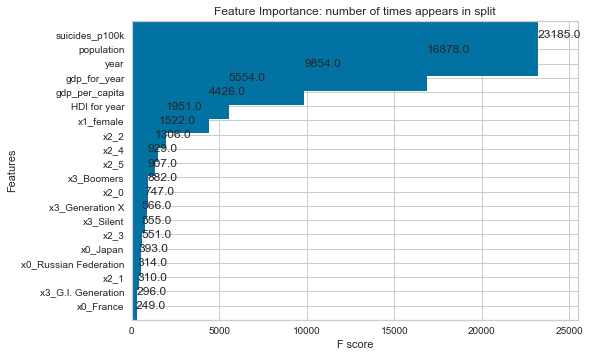

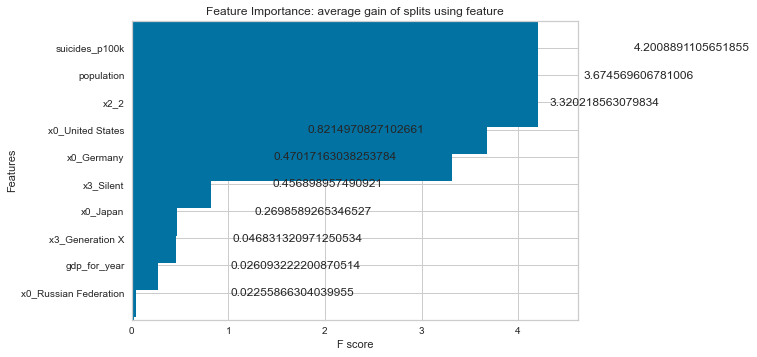

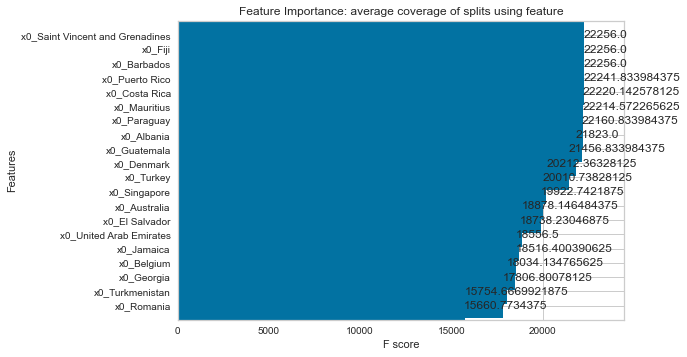

In [467]:
from xgboost import plot_importance

#fig, ax = plt.subplots()
plot_importance(xgb_reg, height=5.8, max_num_features=20,importance_type='weight',title='Feature Importance: number of times appears in split') #number of times feature appears in a tree
plot_importance(xgb_reg, height=5.8, max_num_features=10,importance_type='gain',title='Feature Importance: average gain of splits using feature') #average gain of splits that use this feature
plot_importance(xgb_reg, height=5.8, max_num_features=20,importance_type='cover',title='Feature Importance: average coverage of splits using feature') #average coverage of splits which use this feature
plt.show()

In [481]:
#data =  xgboost.DMatrix(pd.DataFrame(X_train.toarray(),columns=feature_names), label = y_train)
#https://github.com/dmlc/xgboost/blob/master/demo/gpu_acceleration/shap.ipynb
model.set_param({"predictor": "gpu_predictor"})
shap_values = model.predict(data, pred_contribs=True)
shap_interaction_values = model.predict(data, pred_interactions=True)

In [495]:
X_train.get_shape()

(22256, 121)

Wall time: 50 ms


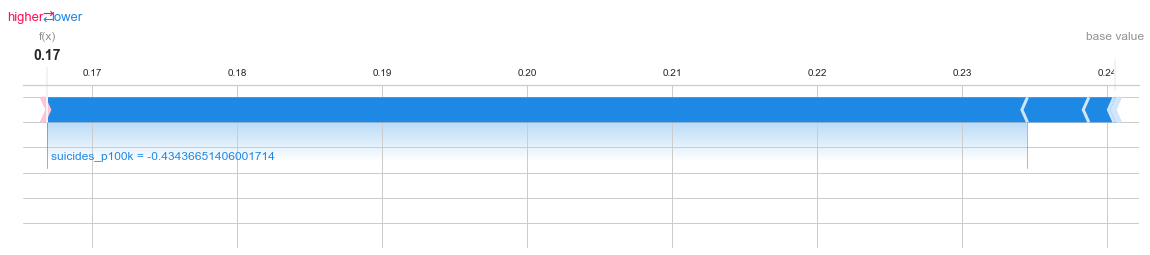

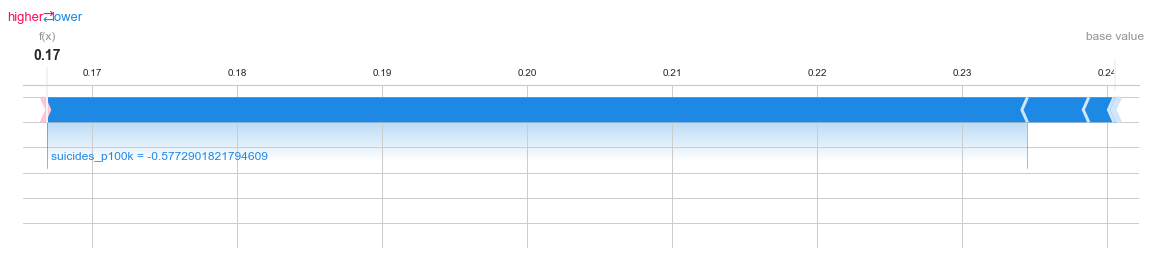

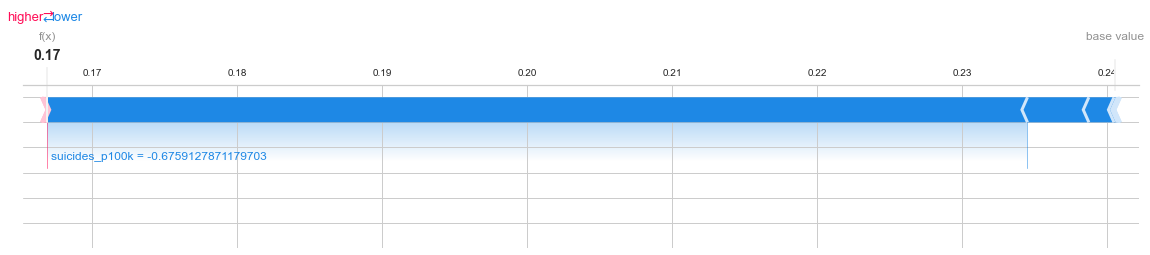

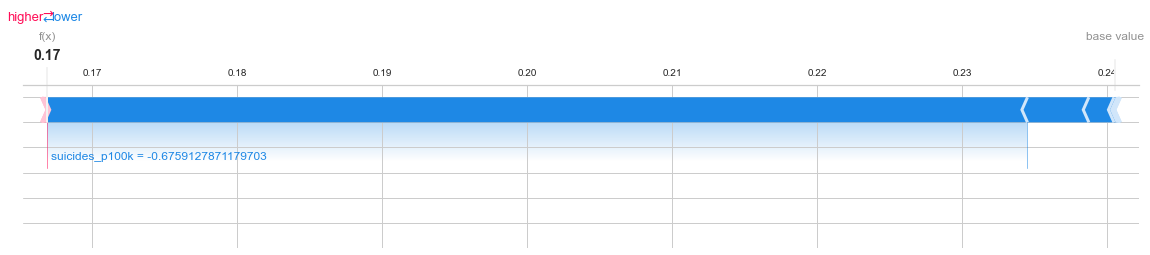

In [498]:
import shap


# shap will call the GPU accelerated version as long as the predictor parameter is set to "gpu_predictor"
explainer = shap.TreeExplainer(model)
%time shap_values = explainer.shap_values(data)

# visualize the first prediction's explanation
for i in [10,100,1000,10000]:
    shap.force_plot(
        explainer.expected_value,
        shap_values[0, :],
        pd.DataFrame(X_train.toarray(),columns=feature_names).iloc[i],
        feature_names=data.feature_names,
        matplotlib=True
    )

In [ ]:
# all data is scaled. 

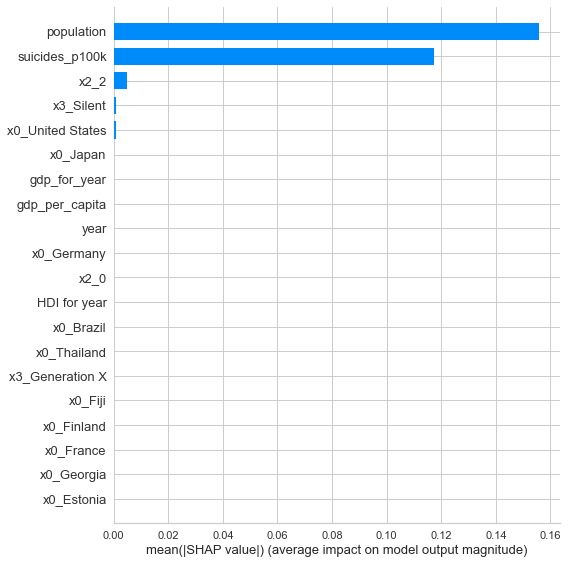

In [501]:
# Show a summary of feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=feature_names)


In [525]:
# final rmse:
dtest =  xgboost.DMatrix(pd.DataFrame(X_test.toarray(),columns=feature_names))

preds = model.predict(dtest)
scaled_test_rmse = np.sqrt(mse(preds,y_test)) 
print('TUNED TEST RMSE', scaled_test_rmse)
#lower than baseline but considerably higher than test. overfitting. in next notebook, experimentation with hyperparam tuning will regularize. will test all versions and record observed errors. 


preds = xgb_reg.predict(X_test)
scaled_test_rmse = np.sqrt(mse(preds,y_test)) 
print('UNTUNED TEST RMSE', scaled_test_rmse)


TUNED TEST RMSE 0.5446507534086875
UNTUNED TEST RMSE 0.04527447028504204


#### SCALED RMSE BASELINE: 0.821
#### SCALED TRAIN RMSE: 0.033
#### TEST XGBOOST TUNED RMSE: 0.5446507534086875

In [526]:

test_rmse = np.sqrt(mse(target_scaler.inverse_transform(preds.reshape(-1,1)),target_scaler.inverse_transform(y_test.reshape(-1,1)))) 
print(test_rmse)


41.80388391450457


#### RMSE BASELINE: 245.782
#### TEST RMSE: 41


# ! MASSIVELY OVERFITTING??

test error is two times greater of model than baseline.  (using dtrain and xgboost.train). 
is it good enough for viz though? 
maybe don't use inbuilt function and just use shap and other stuff separately

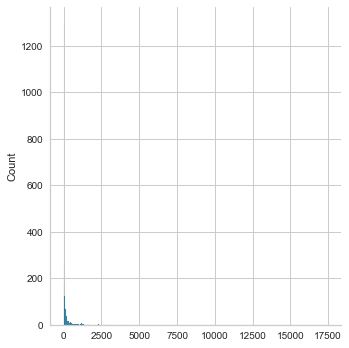

In [522]:
sns.displot(target_scaler.inverse_transform(y_test.reshape(-1,1)).flatten())

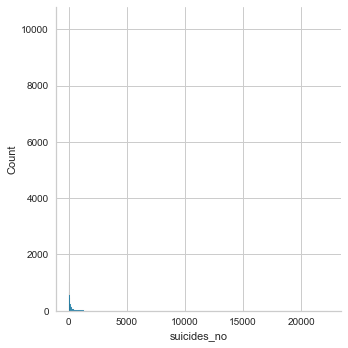

In [523]:
sns.displot(suicides_df['suicides_no'])

In [524]:
xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.07, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, single_precision_histogram=True,
             subsample=1, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

Text(0, 0.5, 'Predicted')

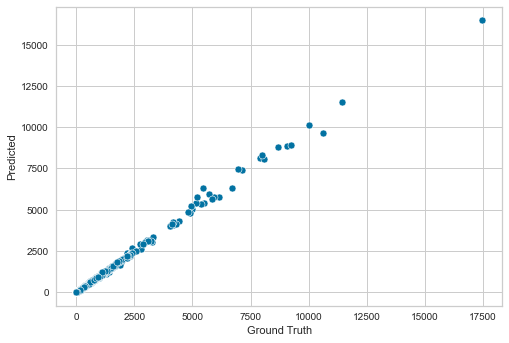

In [544]:
sns_plot = sns.scatterplot(target_scaler.inverse_transform(y_test.reshape(-1,1)).flatten(),target_scaler.inverse_transform(preds.reshape(-1,1)).flatten())
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')

In [560]:
# this is why its useful to keep original X_test in tact :')
X_tets_df = pd.DataFrame(X_test.toarray(),columns = feature_names)
X_tets_df['Residual'] = target_scaler.inverse_transform(y_test.reshape(-1,1)).flatten() - target_scaler.inverse_transform(preds.reshape(-1,1)).flatten()
X_tets_df[np.abs(X_tets_df['Residual'])>42].sort_values('Residual')


,x0_Albania,x0_Antigua and Barbuda,x0_Argentina,x0_Armenia,x0_Aruba,x0_Australia,x0_Austria,x0_Azerbaijan,x0_Bahamas,x0_Bahrain,...,x3_Generation Z,x3_Millenials,x3_Silent,year,population,suicides_p100k,HDI for year,gdp_for_year,gdp_per_capita,Residual
2023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.502825,2.905944,1.493785,0.837670,2.730597,1.070222,-876.024902
691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.032203,2.385079,1.768029,0.691733,0.742534,-0.294350,-579.625000
1836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.150282,3.931582,1.460031,1.338022,3.929514,1.802939,-505.225586
2606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.148588,3.116090,2.326012,1.035726,3.055853,1.267869,-354.085938
1589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.211299,4.188759,0.751742,0.587493,2.159379,0.731792,-282.635254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.030509,2.092625,4.179273,0.691733,-0.095611,-0.774992,286.808594
325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.268361,3.683609,1.314471,1.358870,3.960991,1.827294,344.230957
1912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.683615,4.185691,1.260149,0.347741,1.435918,0.279053,369.983887
1155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.266667,2.255870,4.568489,0.691733,-0.171765,-0.818249,956.473633


In [534]:
test_rmse

41.80388391450457

In [539]:
#just to test next ipynb
pd.DataFrame(X_train.toarray(),columns=feature_names).to_csv('X_train.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
pd.DataFrame(X_test.toarray(),columns=feature_names).to_csv('X_test.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')
pd.DataFrame(X_val.toarray(),columns=feature_names).to_csv('X_val.csv')
pd.DataFrame(y_val).to_csv('y_val.csv')

In [573]:
# this is why its useful to keep original X_test in tact :')

X_tets_df[np.abs(X_tets_df['Residual'])>42].iloc[:,:101].sum().sort_values().tail(15)


x0_Mexico                 1.0
x0_Argentina              1.0
x0_Thailand               1.0
x0_Canada                 1.0
x0_Poland                 1.0
x0_Belarus                3.0
x0_Kazakhstan             3.0
x0_Germany                4.0
x0_Republic of Korea      5.0
x0_Ukraine                6.0
x0_France                 6.0
x0_Brazil                 6.0
x0_United States         14.0
x0_Japan                 15.0
x0_Russian Federation    18.0
dtype: float64

In [566]:
len(set(suicides_df.country))

101

In [ ]:
# mispredicting in Russian Federation, Japan, US. 

In [575]:
X_tets_df[['x0_Russian Federation','x0_Japan','x0_United States']].sum()  #these countries account for half the mispredicted

x0_Russian Federation    32.0
x0_Japan                 40.0
x0_United States         32.0
dtype: float64

In [576]:
rus = 18/32
jp = 15/40
us = 14/32
print(rus, jp, us)

0.5625 0.375 0.4375


In [584]:
c1 = X_tets_df['x0_Russian Federation']==1
c2 = X_tets_df['x0_Japan']==1
c3 = X_tets_df['x0_United States']==1
X_tets_df[np.abs(X_tets_df['Residual'])>42][c1][['Residual','year']] # too lazy to inverse transform the whole damn thing. 
#but just from this seems like Russia maybe follows a slightly different pattern to most other countries. This is what SHAP might help us see

,Residual,year
78,-235.110840,0.441807
133,182.578369,1.386440
691,-579.625000,1.032203
990,-100.770508,0.087570
995,74.694275,-1.447457
1155,956.473633,-0.266667
1268,85.414062,-0.857062
1311,-204.663086,-0.384746
1335,261.966797,1.268361
1397,219.545654,0.441807


In [585]:
X_tets_df[np.abs(X_tets_df['Residual'])>42][c2][['Residual']]


,Residual
122,-64.506348
325,344.230957
507,103.634277
593,-240.233887
643,-232.631836
962,144.248047
1589,-282.635254
1602,-104.055176
1692,61.514282
1836,-505.225586


In [586]:
X_tets_df[np.abs(X_tets_df['Residual'])>42][c3][['Residual']]


,Residual
52,102.317871
396,-51.948242
457,190.116211
522,53.435547
745,-184.177979
967,-79.971008
1013,64.342773
1050,42.428223
1581,-43.651917
1772,51.458496


In [587]:
!pip install graphviz


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

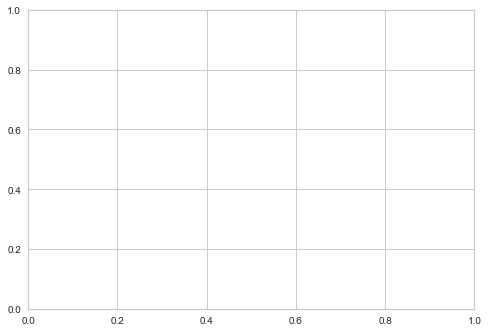

In [589]:
from xgboost import plot_tree

plot_tree(xgb_reg, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(30, 15)